# Time Series Analysis

This notebook will explore shot and goal data over time. First, we'll inspect the shot and goal distributions throughout the time within games, i.e. how the tendency to shoot and score is distributed through minutes 0-59 of a regulation time NHL game. Next, we will inspect how shot and goal trends have changed over seasons. Has scoring increased over time? Do the types of shots show any trends in play style? Do shot/goal locations show any trends?

In [64]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PICKLE_PATH = Path("../pickled_data/")

Import relevant data from pickle

In [65]:
game_plays = pd.read_pickle(PICKLE_PATH / "game_plays")
games = pd.read_pickle(PICKLE_PATH / "games")

In [3]:
game_plays.head()

,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,description,st_x,st_y
0,2016020045_1,2016020045,NaN,NaN,Game Scheduled,NaN,NaN,NaN,1,REGULAR,0,1200.0,2016-10-18 23:40:58,0,0,Game Scheduled,NaN,NaN
1,2016020045_2,2016020045,NaN,NaN,Period Ready,NaN,NaN,NaN,1,REGULAR,0,1200.0,2016-10-19 01:35:28,0,0,Period Ready,NaN,NaN
2,2016020045_3,2016020045,NaN,NaN,Period Start,NaN,NaN,NaN,1,REGULAR,0,1200.0,2016-10-19 01:40:50,0,0,Period Start,NaN,NaN
3,2016020045_4,2016020045,16.0,4.0,Faceoff,NaN,0.0,0.0,1,REGULAR,0,1200.0,2016-10-19 01:40:50,0,0,Jonathan Toews faceoff won against Claude Giroux,0.0,0.0
4,2016020045_5,2016020045,16.0,4.0,Shot,Wrist Shot,-71.0,9.0,1,REGULAR,54,1146.0,2016-10-19 01:41:44,0,0,Artem Anisimov Wrist Shot saved by Michal Neuv...,71.0,-9.0


In [4]:
games.head()

,game_id,season,type,date_time_GMT,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz
0,2016020045,20162017,R,2016-10-19T00:30:00Z,4,16,4,7,home win REG,right,United Center,/api/v1/venues/null,America/Chicago,-5,CDT
1,2017020812,20172018,R,2018-02-07T00:00:00Z,24,7,4,3,away win OT,left,KeyBank Center,/api/v1/venues/null,America/New_York,-4,EDT
2,2015020314,20152016,R,2015-11-24T01:00:00Z,21,52,4,1,away win REG,right,MTS Centre,/api/v1/venues/null,America/Winnipeg,-5,CDT
3,2015020849,20152016,R,2016-02-17T00:00:00Z,52,12,1,2,home win REG,right,PNC Arena,/api/v1/venues/null,America/New_York,-4,EDT
4,2017020586,20172018,R,2017-12-30T03:00:00Z,20,24,1,2,home win REG,left,Honda Center,/api/v1/venues/null,America/Los_Angeles,-7,PDT


In [66]:
# Filter out shots and goals
shots = game_plays[game_plays['event'] == 'Shot']
goals = game_plays[game_plays['event'] == 'Goal']

In [6]:
def calculate_total_time(df):
    """Calculates total elapsed game time in seconds, given period and time_elapsed (seconds).

    Args:
        df: Pandas DataFrame with 'period' and 'periodTime' (in seconds) columns.

    Returns:
        Pandas DataFrame with a new 'total_time' column (in seconds).
        Returns the original DataFrame if there's an error.
    """
    df = df.copy() # create a copy of the DataFrame
    
    try:
        
        df['time_elapsed'] = pd.to_numeric(df['periodTime'], errors='coerce')  # Convert to numeric, handle errors

        # Calculate total seconds for each period:
        df['period_seconds'] = (df['period'] - 1) * 1200  # 1200 seconds per period (20 minutes)

        # Calculate total time:
        df['total_time'] = df['period_seconds'] + df['time_elapsed']

        df = df.drop(columns=['period_seconds'])  # Clean up unnecessary column

        return df
    
    except (TypeError, ValueError) as e:
        print(f"Error during time calculation: {e}")
        return df

shots = calculate_total_time(shots)

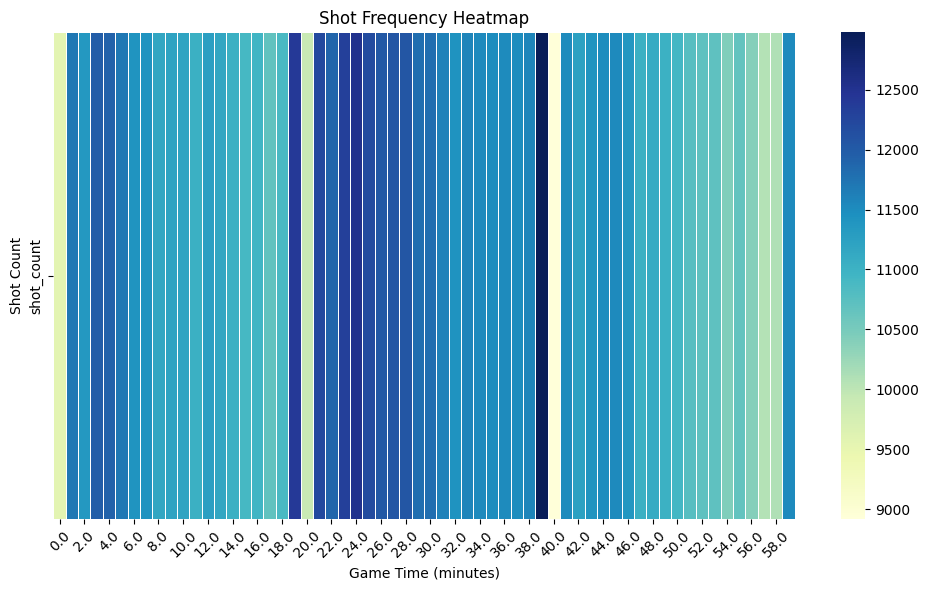

In [7]:
# Heatmap for shot frequency over time of game
# Create bins for time intervals 
bin_size = 60  # Seconds per bin 
bins = range(0, 3601, bin_size)  # Create the bin edges
shots['time_bin'] = pd.cut(shots['total_time'], bins=bins, right=False, labels=False) # Assign each shot to a time bin

# Aggregate shot counts by time bin:
shot_counts = shots.groupby('time_bin').size().reset_index(name='shot_count')

# Convert time_bin back to seconds for plotting:
shot_counts['time_bin_seconds'] = shot_counts['time_bin'] * bin_size

# Create the heatmap:
plt.figure(figsize=(10, 6)) 

# Convert seconds to minutes for the x-axis labels 
shot_counts['time_bin_minutes'] = shot_counts['time_bin_seconds'] / 60

sns.heatmap(shot_counts.pivot_table(index=None, columns='time_bin_minutes', values='shot_count', aggfunc='sum'), cmap="YlGnBu", linewidths=.5)  # Use pivot_table for heatmap
plt.xlabel("Game Time (minutes)")
plt.ylabel("Shot Count")
plt.title("Shot Frequency Heatmap")

plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()


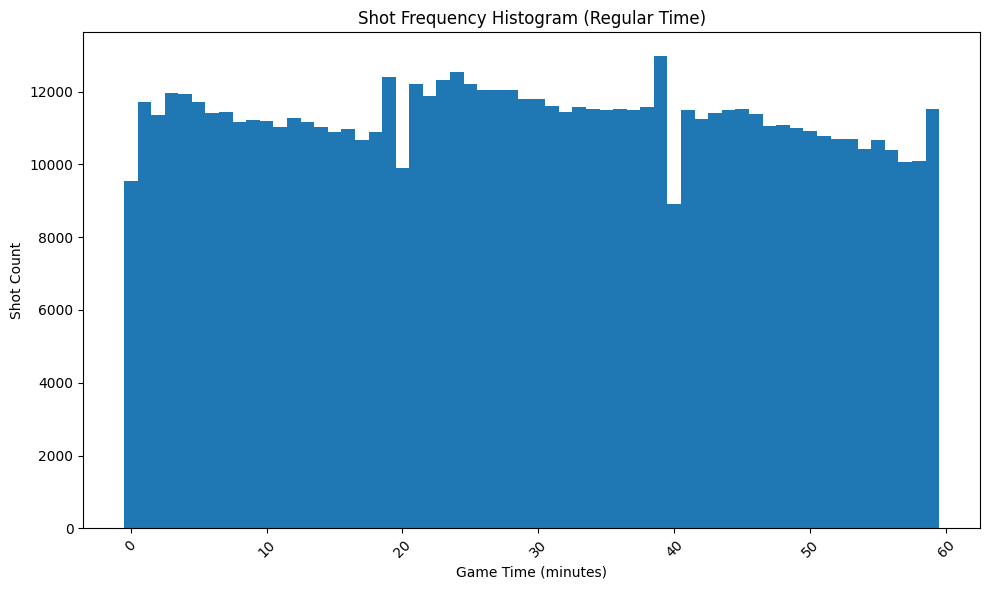

In [8]:
# Histogram of shot count frequency by game time elapsed
plt.figure(figsize=(10, 6))
plt.bar(shot_counts['time_bin_minutes'], shot_counts['shot_count'], width=bin_size/60)  # Use bin_size to determine bar width
plt.xlabel("Game Time (minutes)")
plt.ylabel("Shot Count")
plt.title("Shot Frequency Histogram (Regular Time)")
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()
plt.show()

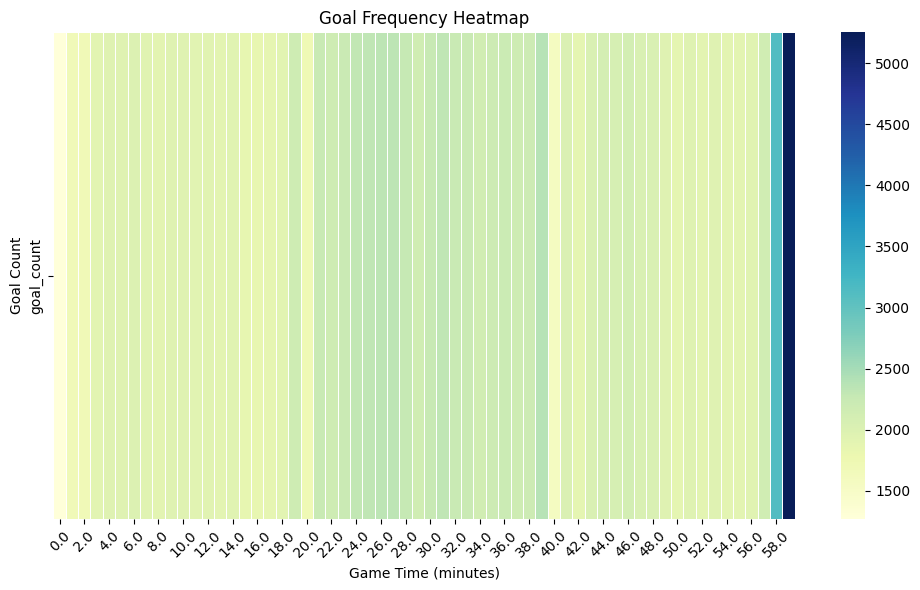

In [9]:
goals = calculate_total_time(goals)

# Create bins for time intervals 
bin_size = 60  # Seconds per bin 
bins = range(0, 3601, bin_size)  # Create the bin edges
goals['time_bin'] = pd.cut(goals['total_time'], bins=bins, right=False, labels=False) # Assign each shot to a time bin

# Aggregate shot counts by time bin:
goal_counts = goals.groupby('time_bin').size().reset_index(name='goal_count')

# Convert time_bin back to seconds for plotting:
goal_counts['time_bin_seconds'] = goal_counts['time_bin'] * bin_size

# Create the heatmap:
plt.figure(figsize=(10, 6)) 

# Convert seconds to minutes for the x-axis labels 
goal_counts['time_bin_minutes'] = goal_counts['time_bin_seconds'] / 60

sns.heatmap(goal_counts.pivot_table(index=None, columns='time_bin_minutes', values='goal_count', aggfunc='sum'), cmap="YlGnBu", linewidths=.5)  # Use pivot_table for heatmap
plt.xlabel("Game Time (minutes)")
plt.ylabel("Goal Count")
plt.title("Goal Frequency Heatmap")

plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

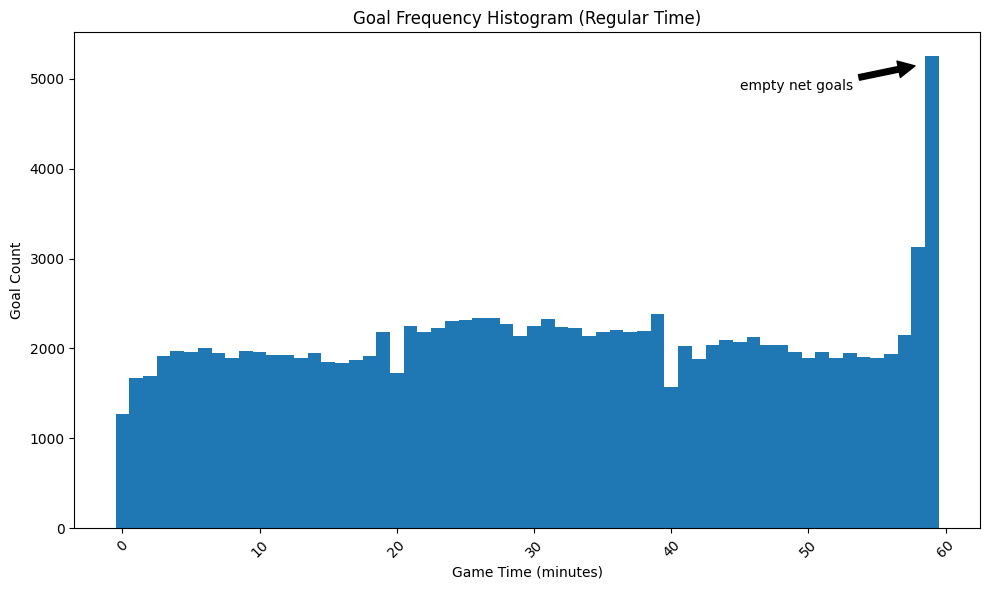

In [10]:
# Histogram of shot count frequency by game time elapsed
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(goal_counts['time_bin_minutes'], goal_counts['goal_count'], width=bin_size/60)  # Use bin_size to determine bar width
ax.annotate("empty net goals", xy=(58, 5150), xytext=(45, 5000), va="top", ha="left", arrowprops=dict(facecolor='black', shrink=0.05))
plt.xlabel("Game Time (minutes)")
plt.ylabel("Goal Count")
plt.title("Goal Frequency Histogram (Regular Time)")
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()
plt.show()

We can merge in the season to the game_plays frame. Then perform aggregations with the full data surround the play.

In [68]:
game_plays = pd.merge(game_plays, games[['game_id', 'season']], how="left", on="game_id")

In [69]:
game_plays.dtypes

play_id                 object
game_id                  int64
team_id_for            float64
team_id_against        float64
event                   object
secondaryType           object
x                      float64
y                      float64
period                   int64
periodType              object
periodTime               int64
periodTimeRemaining    float64
dateTime                object
goals_away               int64
goals_home               int64
description             object
st_x                   float64
st_y                   float64
season                   int64
dtype: object

To simplify things and make them a bit cleaner, let's change the season data to align to the year end for each season

In [70]:
season_replacements = {
    20002001: 2001, 
    20012002: 2002,
    20022003: 2003, 
    20032004: 2004, 
    20052006: 2006,
    20062007: 2007,
    20072008: 2008, 
    20082009: 2009, 
    20092010: 2010,
    20102011: 2011,
    20112012: 2012,
    20122013: 2013, 
    20132014: 2014,
    20142015: 2015,
    20152016: 2016,
    20162017: 2017, 
    20172018: 2018,
    20182019: 2019,
    20192020: 2020
}

game_plays['season'] = game_plays['season'].replace(season_replacements)

In [71]:
shots = game_plays.loc[game_plays['event'] == 'Shot']

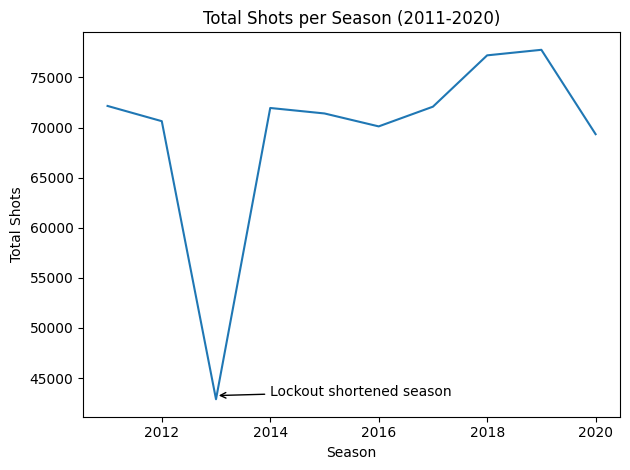

In [27]:
total_shots_after_2010 = shots[shots['season'] > 2010]
ax = total_shots_after_2010.groupby('season')['play_id'].count().plot(kind="line")
ax.annotate("Lockout shortened season", xy=(2013, 43250), xytext=(2014, 43250), arrowprops=dict(arrowstyle='->'))
plt.xlabel('Season')
plt.ylabel('Total Shots')
plt.title('Total Shots per Season (2011-2020)')
plt.tight_layout()
plt.show()

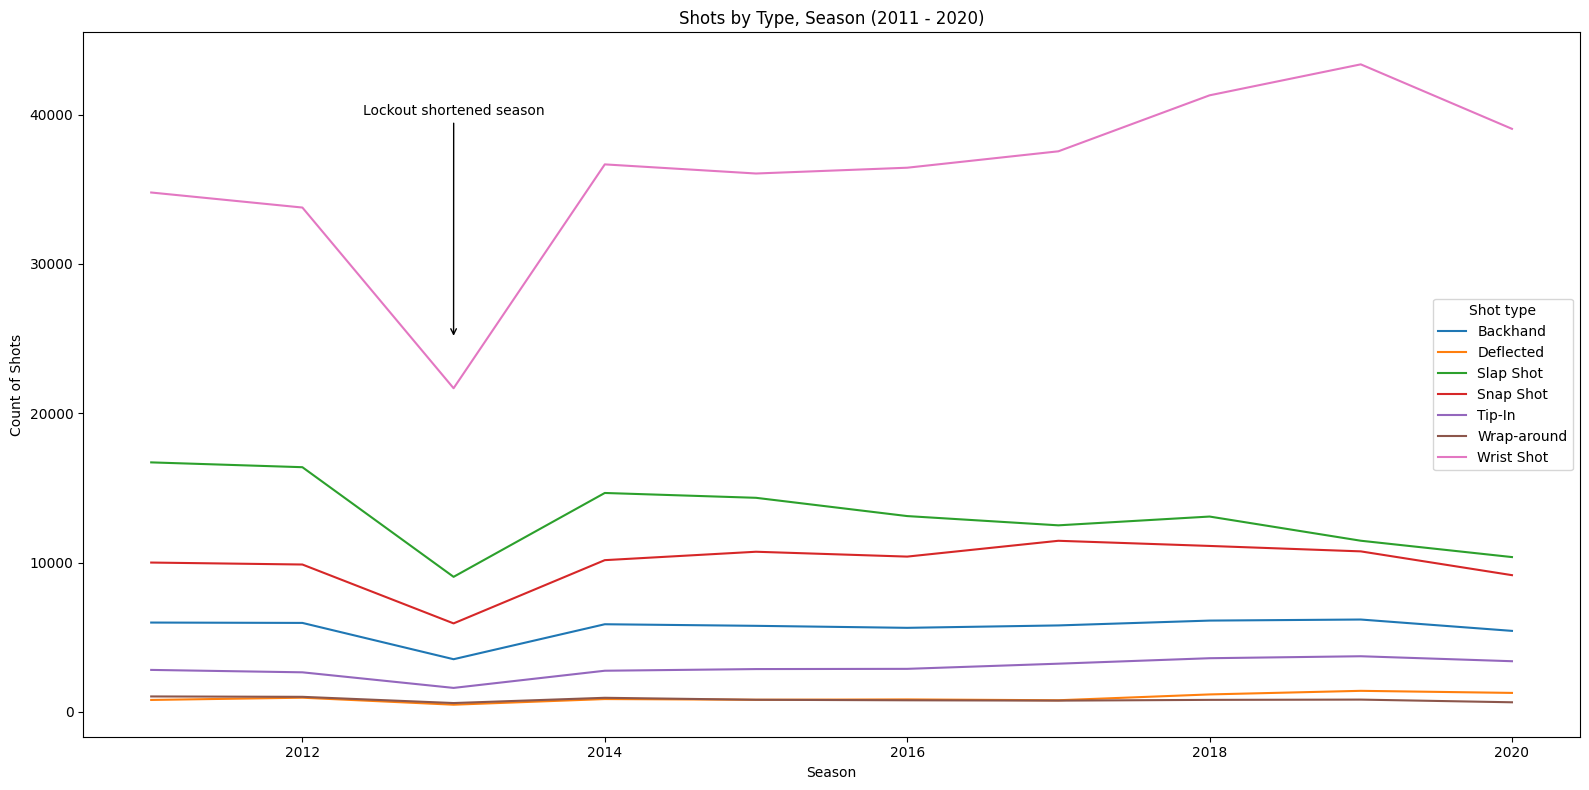

In [37]:

ax = total_shots_after_2010.groupby(['season', 'secondaryType'])['play_id'].count().unstack().plot(kind="line", figsize=(16, 8))
ax.annotate("Lockout shortened season", xy=(2013, 25000), xytext=(2012.4, 40000), arrowprops=dict(arrowstyle='->'))
plt.title('Shots by Type, Season (2011 - 2020)')
plt.xlabel('Season')
plt.ylabel('Count of Shots')
plt.legend(title="Shot type")
plt.tight_layout()
plt.show()

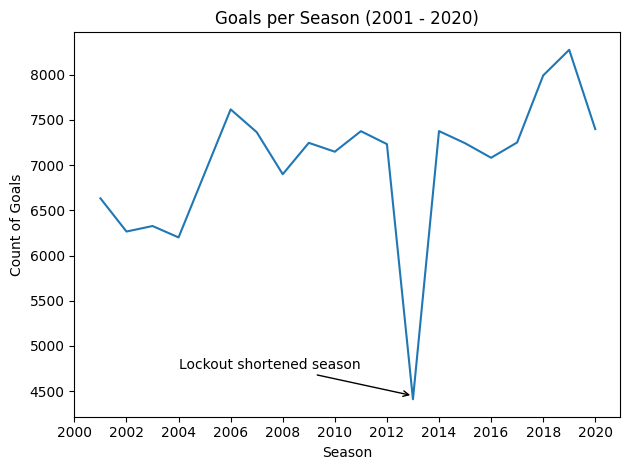

In [75]:
goals = game_plays.loc[game_plays['event'] == 'Goal']
ax = goals.groupby('season')['play_id'].count().plot(kind="line")
ax.annotate("Lockout shortened season", xy=(2013, 4450), xytext=(2004, 4750), arrowprops=dict(arrowstyle='->'))
plt.xlabel('Season')
plt.ylabel('Count of Goals')
plt.title("Goals per Season (2001 - 2020)")
plt.xticks(np.arange(2000, 2021, 2))
plt.tight_layout()
plt.show()

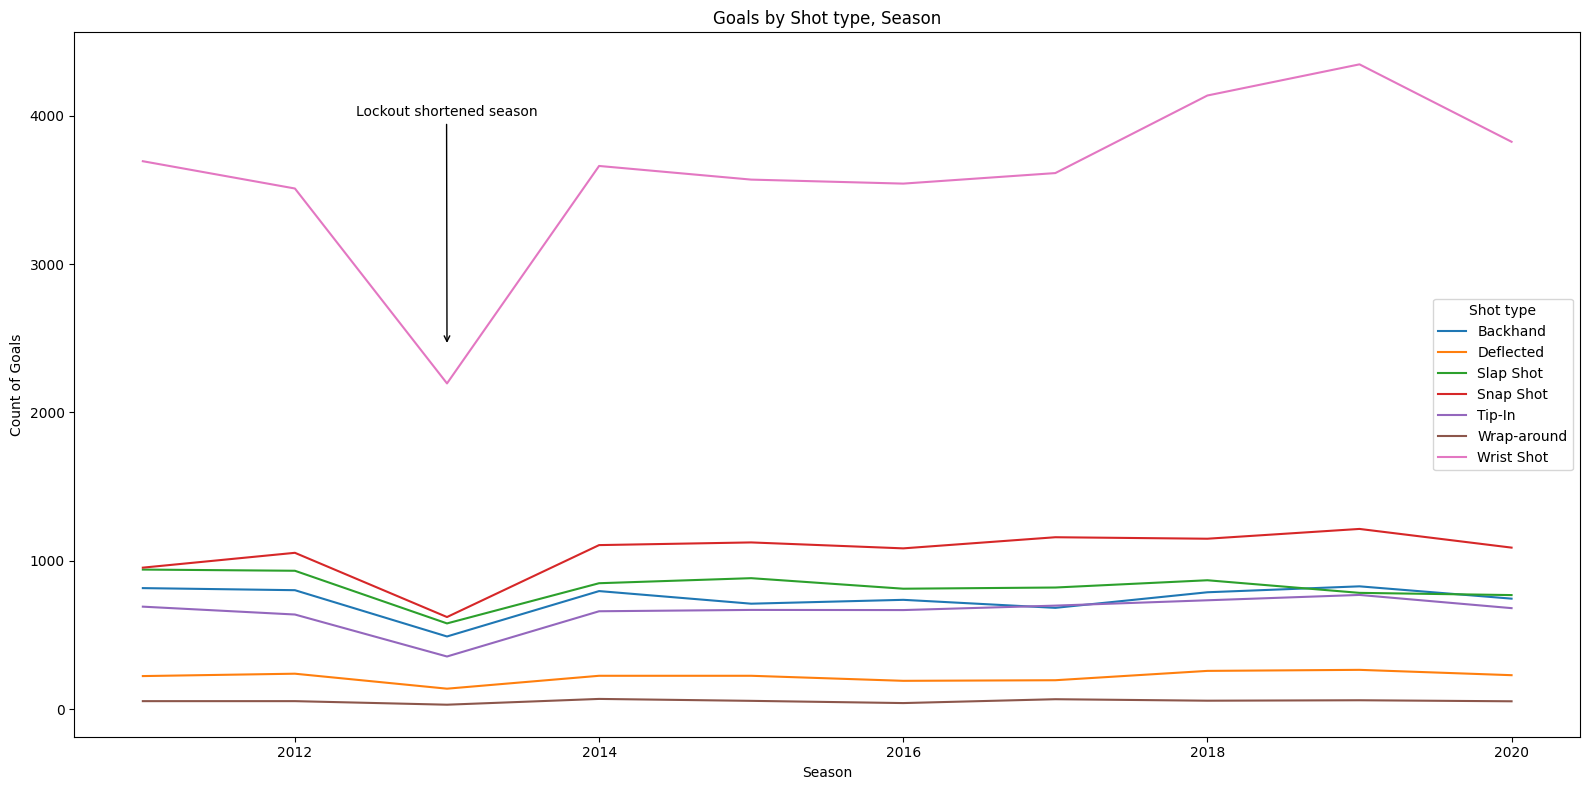

In [79]:
goals_after_2010 = goals[goals['season'] > 2010]
ax = goals_after_2010.groupby(['season', 'secondaryType'])['play_id'].count().unstack().plot(kind="line", figsize=(16, 8))
ax.annotate("Lockout shortened season", xy=(2013, 2450), xytext=(2012.4, 4000), arrowprops=dict(arrowstyle='->'))
plt.title('Goals by Shot type, Season')
plt.xlabel('Season')
plt.ylabel('Count of Goals')
plt.legend(title="Shot type")
plt.tight_layout()
plt.show()